# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [34]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.5324879360542643, pvalue=6.1007457661853726e-176)

In [27]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [28]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [29]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [30]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 16)

In [31]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,0.058483,-0.082086,-0.199875,0.194877,0.502350,-0.308224,0.033812,-0.231517,-0.090058,-0.000856,-0.352808,-0.189532,-0.569163,0.188965,0.153867,-0.225302,0.779739,1,animal
1,1,-0.166036,-0.208936,-0.065722,0.086583,0.415832,-0.059183,0.197501,0.267182,-0.245415,0.122019,-0.365080,0.204105,-0.158481,0.168652,0.248365,0.038184,0.798485,13,home decor
2,2,-0.271117,-0.059406,-0.310249,-0.365451,0.593264,-0.205329,-0.089593,0.222606,-0.405435,0.213888,-0.204843,-0.182588,0.106699,0.275967,0.097938,-0.094526,0.752845,18,musical instrument
4,4,-0.096295,-0.096725,-0.443046,-0.121340,0.432454,0.182330,0.048388,0.197389,-0.141751,-0.049741,-0.235596,-0.071778,-0.346555,-0.197042,-0.400532,-0.319990,0.794466,9,electronic device
5,5,0.045648,-0.057522,-0.327324,-0.143554,0.088708,0.007568,0.095230,-0.037648,-0.137376,-0.041689,-0.419284,-0.074120,-0.142726,0.074861,-0.375969,-0.112216,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.357850,0.228089,0.433550,-0.070286,-0.021952,-0.341652,-0.040207,-0.059503,0.167477,-0.404975,-0.188073,0.148179,-0.117837,0.408283,0.564341,0.091149,0.803129,24,toy
1848,1848,-0.060791,0.004216,-0.330039,0.102997,0.493906,-0.099803,0.074577,-0.031081,-0.277580,-0.281226,-0.088801,0.444189,-0.170299,0.276952,0.007678,0.339744,0.765881,10,food
1850,1850,-0.248176,-0.009530,-0.081562,0.107144,0.613472,0.039324,0.144784,0.030562,-0.234714,-0.405207,-0.203786,0.366379,-0.180630,0.221737,0.062564,0.238494,0.843158,10,food
1851,1851,0.166072,-0.063773,-0.158044,0.147144,0.426531,-0.203575,0.155251,-0.248491,-0.062016,0.059737,-0.348859,-0.364750,-0.508154,0.108109,0.082035,-0.201371,0.800163,1,animal


### Cartesian

In [32]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.058483,-0.082086,-0.199875,0.194877,0.502350,-0.308224,0.033812,-0.231517,-0.090058,-0.000856,-0.352808,-0.189532,-0.569163,0.188965,0.153867,-0.225302
1,-0.166036,-0.208936,-0.065722,0.086583,0.415832,-0.059183,0.197501,0.267182,-0.245415,0.122019,-0.365080,0.204105,-0.158481,0.168652,0.248365,0.038184
2,-0.271117,-0.059406,-0.310249,-0.365451,0.593264,-0.205329,-0.089593,0.222606,-0.405435,0.213888,-0.204843,-0.182588,0.106699,0.275967,0.097938,-0.094526
3,-0.233568,0.025450,-0.257919,0.080984,0.336530,-0.100998,0.053563,0.238404,-0.318429,-0.130210,-0.405963,0.215876,-0.109323,0.272701,0.028325,0.217291
4,-0.096295,-0.096725,-0.443046,-0.121340,0.432454,0.182330,0.048388,0.197389,-0.141751,-0.049741,-0.235596,-0.071778,-0.346555,-0.197042,-0.400532,-0.319990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.268853,-0.175781,-0.449258,0.254559,0.381767,-0.054150,-0.172794,0.180884,-0.105843,0.194684,-0.270909,0.221835,-0.510931,0.498483,-0.015307,0.094401
1850,-0.248176,-0.009530,-0.081562,0.107144,0.613472,0.039324,0.144784,0.030562,-0.234714,-0.405207,-0.203786,0.366379,-0.180630,0.221737,0.062564,0.238494
1851,0.166072,-0.063773,-0.158044,0.147144,0.426531,-0.203575,0.155251,-0.248491,-0.062016,0.059737,-0.348859,-0.364750,-0.508154,0.108109,0.082035,-0.201371
1852,-0.206514,0.039568,-0.456309,0.125077,0.393549,-0.154866,-0.195732,-0.113488,-0.216123,-0.414842,-0.237096,0.045424,-0.407028,0.182179,-0.088594,0.008324


In [35]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     48.77
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          1.45e-128
Time:                        11:06:28   Log-Likelihood:                -2302.5
No. Observations:                1854   AIC:                             4639.
Df Residuals:                    1837   BIC:                             4733.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7519      0.106     -7.084      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Polar coordinates

In [11]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


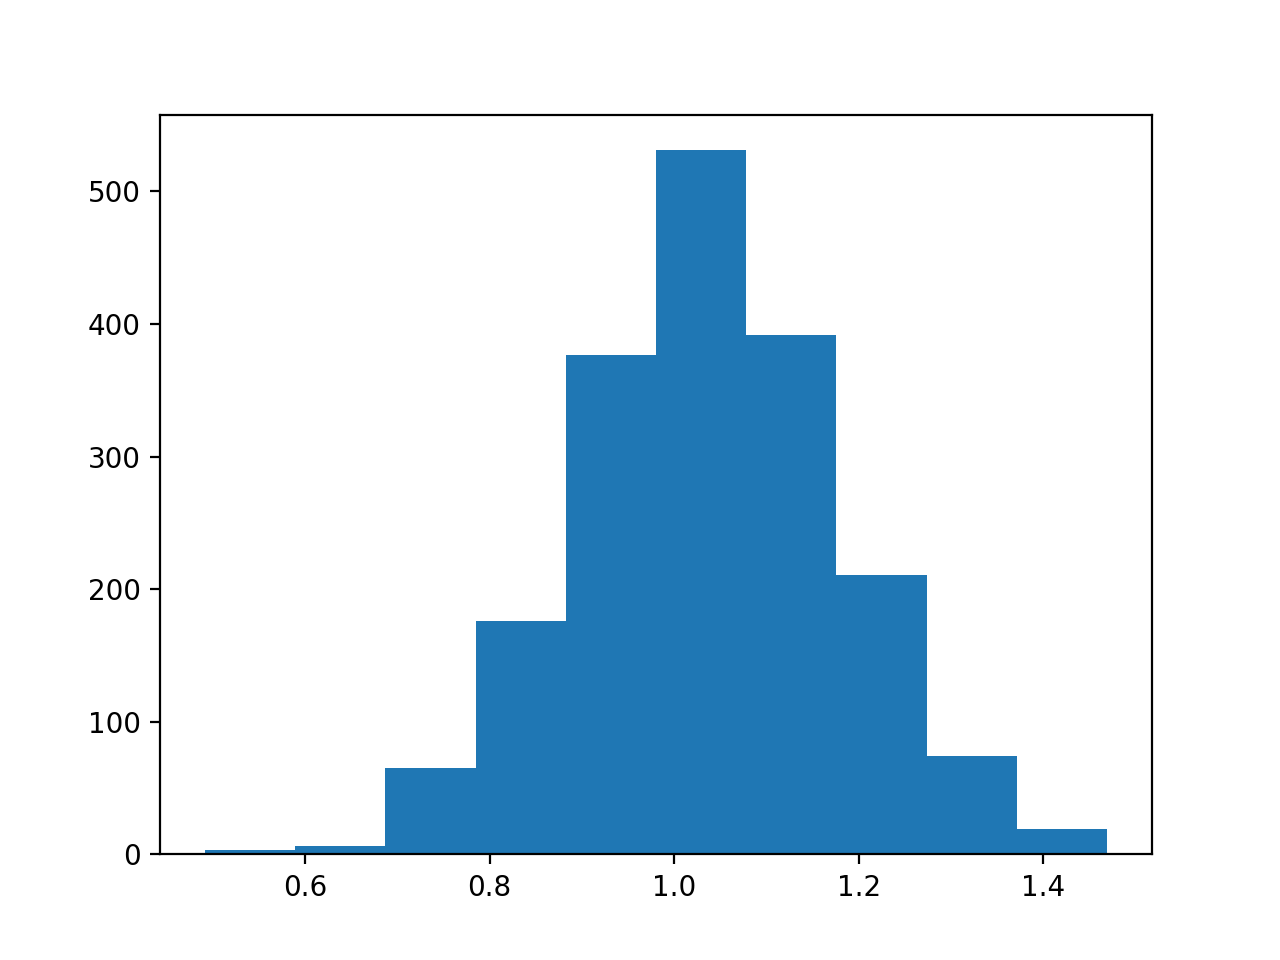

(array([  3.,   6.,  65., 176., 377., 531., 392., 211.,  74.,  19.]),
 array([0.49178069, 0.58949693, 0.68721318, 0.78492942, 0.88264567,
        0.98036191, 1.07807816, 1.1757944 , 1.27351065, 1.37122689,
        1.46894314]),
 <BarContainer object of 10 artists>)

In [36]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [37]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.717
Date:                Wed, 28 Sep 2022   Prob (F-statistic):             0.0169
Time:                        11:06:34   Log-Likelihood:                -2627.9
No. Observations:                1854   AIC:                             5260.
Df Residuals:                    1852   BIC:                             5271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3918      0.164     -2.391      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### KMeans

In [38]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1436.7656500204066, 1237.8585688840778, 1115.7059001487032, 1033.4995611216896, 960.0726635513458, 904.0105345084083, 852.7776469068316, 813.0171475048318, 784.7222446187295, 757.3057212299763, 740.1300851753175, 722.6328237168854, 710.7725696635073, 697.124148194513]


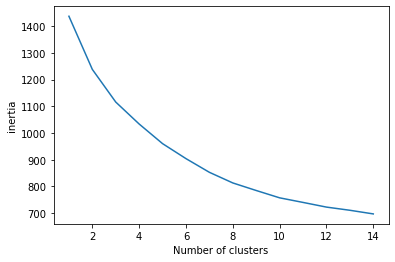

In [39]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [40]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-3.23371688e-01, -1.07040278e-01, -3.41479239e-01,
         2.25089850e-02,  4.49222107e-01, -1.91369388e-01,
        -1.21040488e-01,  2.19500755e-01, -1.73050354e-01,
         3.66365150e-02, -1.11883848e-01,  1.36452300e-01,
        -3.10356580e-01,  1.98545651e-01, -2.78975703e-02,
         9.26189871e-03],
       [-8.34266649e-02, -3.73013351e-04, -2.28411055e-01,
         2.03573476e-03,  3.85694071e-01,  1.08974596e-01,
         8.55082348e-02,  5.13067495e-02, -3.31225435e-01,
        -4.38108679e-02, -1.33204148e-01,  2.23868129e-01,
        -2.09080008e-01,  2.33533239e-01,  2.39966579e-02,
         1.72324130e-01],
       [ 2.23552435e-02,  1.58489814e-01, -2.21829233e-01,
         1.17281039e-01, -5.55250103e-03, -6.87430366e-02,
        -2.74989884e-01, -4.17275947e-01, -1.46245225e-01,
        -3.37629010e-01, -1.77150204e-01,  1.47613762e-01,
         7.39320519e-02, -2.19404966e-02, -1.66639145e-01,
         9.81211238e-02],
       [ 9.25239452e-02, -5.23336508e

In [41]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     8.269
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.28e-17
Time:                        11:07:03   Log-Likelihood:                -620.77
No. Observations:                 480   AIC:                             1276.
Df Residuals:                     463   BIC:                             1346.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.2058      0.255     -4.720      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.05670
Date:                Wed, 28 Sep 2022   Prob (F-statistic):              0.812
Time:                        11:07:29   Log-Likelihood:                -681.06
No. Observations:                 480   AIC:                             1366.
Df Residuals:                     478   BIC:                             1374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0766      0.322      0.238      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     18.92
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.42e-43
Time:                        11:07:52   Log-Likelihood:                -749.46
No. Observations:                 617   AIC:                             1533.
Df Residuals:                     600   BIC:                             1608.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6306      0.245     -2.572      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     40.68
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.52e-10
Time:                        11:08:04   Log-Likelihood:                -855.72
No. Observations:                 617   AIC:                             1715.
Df Residuals:                     615   BIC:                             1724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.1546      0.338     -6.378      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     7.343
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.30e-14
Time:                        11:08:11   Log-Likelihood:                -320.44
No. Observations:                 262   AIC:                             674.9
Df Residuals:                     245   BIC:                             735.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4530      0.418     -1.083      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     32.07
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.93e-08
Time:                        11:08:30   Log-Likelihood:                -356.53
No. Observations:                 262   AIC:                             717.1
Df Residuals:                     260   BIC:                             724.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.3226      0.410      5.663      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.015
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.91e-12
Time:                        11:08:36   Log-Likelihood:                -656.97
No. Observations:                 495   AIC:                             1348.
Df Residuals:                     478   BIC:                             1419.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.2813      0.314     -4.083      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.966
Date:                Wed, 28 Sep 2022   Prob (F-statistic):              0.161
Time:                        11:08:54   Log-Likelihood:                -701.39
No. Observations:                 495   AIC:                             1407.
Df Residuals:                     493   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4813      0.343      1.402      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.25969602859289287

In [50]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.03725679260243575

### Typicality

In [51]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [52]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,0.058483,-0.082086,-0.199875,0.194877,0.502350,-0.308224,0.033812,-0.231517,-0.090058,...,-0.352808,-0.189532,-0.569163,0.188965,0.153867,-0.225302,0.779739,1,animal,0.810913
1,1,-0.166036,-0.208936,-0.065722,0.086583,0.415832,-0.059183,0.197501,0.267182,-0.245415,...,-0.365080,0.204105,-0.158481,0.168652,0.248365,0.038184,0.798485,13,home decor,0.247628
2,2,-0.271117,-0.059406,-0.310249,-0.365451,0.593264,-0.205329,-0.089593,0.222606,-0.405435,...,-0.204843,-0.182588,0.106699,0.275967,0.097938,-0.094526,0.752845,18,musical instrument,0.624589
4,4,-0.096295,-0.096725,-0.443046,-0.121340,0.432454,0.182330,0.048388,0.197389,-0.141751,...,-0.235596,-0.071778,-0.346555,-0.197042,-0.400532,-0.319990,0.794466,9,electronic device,0.522380
5,5,0.045648,-0.057522,-0.327324,-0.143554,0.088708,0.007568,0.095230,-0.037648,-0.137376,...,-0.419284,-0.074120,-0.142726,0.074861,-0.375969,-0.112216,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.357850,0.228089,0.433550,-0.070286,-0.021952,-0.341652,-0.040207,-0.059503,0.167477,...,-0.188073,0.148179,-0.117837,0.408283,0.564341,0.091149,0.803129,24,toy,0.246697
1848,1848,-0.060791,0.004216,-0.330039,0.102997,0.493906,-0.099803,0.074577,-0.031081,-0.277580,...,-0.088801,0.444189,-0.170299,0.276952,0.007678,0.339744,0.765881,10,food,0.786900
1850,1850,-0.248176,-0.009530,-0.081562,0.107144,0.613472,0.039324,0.144784,0.030562,-0.234714,...,-0.203786,0.366379,-0.180630,0.221737,0.062564,0.238494,0.843158,10,food,0.770485
1851,1851,0.166072,-0.063773,-0.158044,0.147144,0.426531,-0.203575,0.155251,-0.248491,-0.062016,...,-0.348859,-0.364750,-0.508154,0.108109,0.082035,-0.201371,0.800163,1,animal,0.764335


In [53]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     50.29
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          8.68e-124
Time:                        11:10:18   Log-Likelihood:                -1561.1
No. Observations:                1324   AIC:                             3156.
Df Residuals:                    1307   BIC:                             3244.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2179      0.122      1.793      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     22.88
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.92e-06
Time:                        11:10:42   Log-Likelihood:                -1867.3
No. Observations:                1324   AIC:                             3739.
Df Residuals:                    1322   BIC:                             3749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9392      0.196      4.783      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     39.12
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          5.35e-104
Time:                        11:10:50   Log-Likelihood:                -1606.2
No. Observations:                1324   AIC:                             3248.
Df Residuals:                    1306   BIC:                             3342.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8177      0.126     -6.492      0.0

In [56]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     24.89
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.46e-11
Time:                        11:10:58   Log-Likelihood:                -1854.2
No. Observations:                1324   AIC:                             3714.
Df Residuals:                    1321   BIC:                             3730.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9996      0.145      6.884      0.0

##### Cluster level typicality

In [57]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.058483,-0.082086,-0.199875,0.194877,0.502350,-0.308224,0.033812,-0.231517,-0.090058,...,-0.189532,-0.569163,0.188965,0.153867,-0.225302,0.779739,1,animal,3,0.810913
1,1,-0.166036,-0.208936,-0.065722,0.086583,0.415832,-0.059183,0.197501,0.267182,-0.245415,...,0.204105,-0.158481,0.168652,0.248365,0.038184,0.798485,13,home decor,1,0.247628
2,2,-0.271117,-0.059406,-0.310249,-0.365451,0.593264,-0.205329,-0.089593,0.222606,-0.405435,...,-0.182588,0.106699,0.275967,0.097938,-0.094526,0.752845,18,musical instrument,0,0.624589
3,4,-0.096295,-0.096725,-0.443046,-0.121340,0.432454,0.182330,0.048388,0.197389,-0.141751,...,-0.071778,-0.346555,-0.197042,-0.400532,-0.319990,0.794466,9,electronic device,3,0.522380
4,5,0.045648,-0.057522,-0.327324,-0.143554,0.088708,0.007568,0.095230,-0.037648,-0.137376,...,-0.074120,-0.142726,0.074861,-0.375969,-0.112216,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.357850,0.228089,0.433550,-0.070286,-0.021952,-0.341652,-0.040207,-0.059503,0.167477,...,0.148179,-0.117837,0.408283,0.564341,0.091149,0.803129,24,toy,3,0.246697
1320,1848,-0.060791,0.004216,-0.330039,0.102997,0.493906,-0.099803,0.074577,-0.031081,-0.277580,...,0.444189,-0.170299,0.276952,0.007678,0.339744,0.765881,10,food,1,0.786900
1321,1850,-0.248176,-0.009530,-0.081562,0.107144,0.613472,0.039324,0.144784,0.030562,-0.234714,...,0.366379,-0.180630,0.221737,0.062564,0.238494,0.843158,10,food,1,0.770485
1322,1851,0.166072,-0.063773,-0.158044,0.147144,0.426531,-0.203575,0.155251,-0.248491,-0.062016,...,-0.364750,-0.508154,0.108109,0.082035,-0.201371,0.800163,1,animal,3,0.764335


In [58]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     4.306
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.91e-08
Time:                        11:11:08   Log-Likelihood:                -412.27
No. Observations:                 315   AIC:                             860.5
Df Residuals:                     297   BIC:                             928.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8962      0.353     -2.536      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 0: radius vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.292
Date:                Wed, 28 Sep 2022   Prob (F-statistic):              0.276
Time:                        11:13:10   Log-Likelihood:                -445.67
No. Observations:                 315   AIC:                             897.3
Df Residuals:                     312   BIC:                             908.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5833      0.484      1.205      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     16.08
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           4.17e-37
Time:                        11:13:17   Log-Likelihood:                -584.73
No. Observations:                 491   AIC:                             1205.
Df Residuals:                     473   BIC:                             1281.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0374      0.284     -3.648      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     28.17
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.64e-12
Time:                        11:13:31   Log-Likelihood:                -669.87
No. Observations:                 491   AIC:                             1346.
Df Residuals:                     488   BIC:                             1358.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.2233      0.385     -5.781      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     4.746
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.51e-08
Time:                        11:13:40   Log-Likelihood:                -228.85
No. Observations:                 187   AIC:                             493.7
Df Residuals:                     169   BIC:                             551.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0209      0.554     -0.038      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [64]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     11.00
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.07e-05
Time:                        11:13:50   Log-Likelihood:                -254.78
No. Observations:                 187   AIC:                             515.6
Df Residuals:                     184   BIC:                             525.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.7378      0.584      2.974      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.717
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.05e-13
Time:                        11:13:56   Log-Likelihood:                -418.19
No. Observations:                 331   AIC:                             872.4
Df Residuals:                     313   BIC:                             940.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.9236      0.430     -4.477      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     12.08
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           8.67e-06
Time:                        11:14:08   Log-Likelihood:                -457.91
No. Observations:                 331   AIC:                             921.8
Df Residuals:                     328   BIC:                             933.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1647      0.433      0.381      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [67]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.29533516119911696

In [68]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.07257487579283917

In [88]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     42.59
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.19e-18
Time:                        11:53:41   Log-Likelihood:                -1837.3
No. Observations:                1324   AIC:                             3681.
Df Residuals:                    1321   BIC:                             3696.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1533      0.024      6.338      0.0

### Typicality calculated by cluster

In [69]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.058483,-0.082086,-0.199875,0.194877,0.502350,-0.308224,0.033812,-0.231517,-0.090058,...,-0.189532,-0.569163,0.188965,0.153867,-0.225302,0.779739,1,animal,3,0.417774
1,1,-0.166036,-0.208936,-0.065722,0.086583,0.415832,-0.059183,0.197501,0.267182,-0.245415,...,0.204105,-0.158481,0.168652,0.248365,0.038184,0.798485,13,home decor,1,0.064315
2,2,-0.271117,-0.059406,-0.310249,-0.365451,0.593264,-0.205329,-0.089593,0.222606,-0.405435,...,-0.182588,0.106699,0.275967,0.097938,-0.094526,0.752845,18,musical instrument,0,0.287141
3,4,-0.096295,-0.096725,-0.443046,-0.121340,0.432454,0.182330,0.048388,0.197389,-0.141751,...,-0.071778,-0.346555,-0.197042,-0.400532,-0.319990,0.794466,9,electronic device,3,0.030377
4,5,0.045648,-0.057522,-0.327324,-0.143554,0.088708,0.007568,0.095230,-0.037648,-0.137376,...,-0.074120,-0.142726,0.074861,-0.375969,-0.112216,0.806000,12,furniture,3,0.069172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.357850,0.228089,0.433550,-0.070286,-0.021952,-0.341652,-0.040207,-0.059503,0.167477,...,0.148179,-0.117837,0.408283,0.564341,0.091149,0.803129,24,toy,3,-0.001987
1320,1848,-0.060791,0.004216,-0.330039,0.102997,0.493906,-0.099803,0.074577,-0.031081,-0.277580,...,0.444189,-0.170299,0.276952,0.007678,0.339744,0.765881,10,food,1,0.489516
1321,1850,-0.248176,-0.009530,-0.081562,0.107144,0.613472,0.039324,0.144784,0.030562,-0.234714,...,0.366379,-0.180630,0.221737,0.062564,0.238494,0.843158,10,food,1,0.464548
1322,1851,0.166072,-0.063773,-0.158044,0.147144,0.426531,-0.203575,0.155251,-0.248491,-0.062016,...,-0.364750,-0.508154,0.108109,0.082035,-0.201371,0.800163,1,animal,3,0.392985


In [70]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     38.08
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          1.68e-101
Time:                        11:17:59   Log-Likelihood:                -1612.2
No. Observations:                1324   AIC:                             3260.
Df Residuals:                    1306   BIC:                             3354.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7323      0.127     -5.750      0.0

In [74]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.655e+31
Date:                Wed, 28 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:22:14   Log-Likelihood:                 43147.
No. Observations:                1324   AIC:                        -8.626e+04
Df Residuals:                    1306   BIC:                        -8.617e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.567e-15   2.65e-16    -13.461      0.0

In [72]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     65.41
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           8.21e-28
Time:                        11:20:18   Log-Likelihood:                -1816.2
No. Observations:                1324   AIC:                             3638.
Df Residuals:                    1321   BIC:                             3654.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8300      0.195     -4.263      0.0

In [73]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     80.98
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           7.74e-19
Time:                        11:21:31   Log-Likelihood:                -1839.3
No. Observations:                1324   AIC:                             3683.
Df Residuals:                    1322   BIC:                             3693.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.7300      0.192      8.999      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     4.396
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           4.21e-08
Time:                        13:45:18   Log-Likelihood:                -411.61
No. Observations:                 315   AIC:                             859.2
Df Residuals:                     297   BIC:                             926.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.4841      0.384     -3.868      0.0

In [90]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.866
Date:                Wed, 28 Sep 2022   Prob (F-statistic):              0.156
Time:                        13:45:21   Log-Likelihood:                -445.09
No. Observations:                 315   AIC:                             896.2
Df Residuals:                     312   BIC:                             907.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8713      0.454      1.920      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     17.02
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.59e-39
Time:                        13:45:24   Log-Likelihood:                -579.51
No. Observations:                 491   AIC:                             1195.
Df Residuals:                     473   BIC:                             1271.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2176      0.287     -4.245      0.0

In [92]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     75.24
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.30e-29
Time:                        13:45:25   Log-Likelihood:                -630.72
No. Observations:                 491   AIC:                             1267.
Df Residuals:                     488   BIC:                             1280.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.7030      0.358     -4.752      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4.627
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.17e-08
Time:                        13:45:26   Log-Likelihood:                -229.61
No. Observations:                 187   AIC:                             495.2
Df Residuals:                     169   BIC:                             553.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1190      0.565     -0.211      0.8

In [94]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     9.660
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           0.000102
Time:                        13:45:27   Log-Likelihood:                -256.01
No. Observations:                 187   AIC:                             518.0
Df Residuals:                     184   BIC:                             527.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.3919      0.589      4.063      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [95]:
### cluster 3: cartesian coordinates and typicality vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     6.803
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.57e-14
Time:                        13:45:27   Log-Likelihood:                -417.63
No. Observations:                 331   AIC:                             871.3
Df Residuals:                     313   BIC:                             939.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.8215      0.439     -4.149      0.0

In [96]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.16e-05
Time:                        13:45:27   Log-Likelihood:                -458.83
No. Observations:                 331   AIC:                             923.7
Df Residuals:                     328   BIC:                             935.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1393      0.436      0.319      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [97]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.30090429043438083

In [98]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.1194831028502834